In [2]:
import requests
from bs4 import BeautifulSoup
from collections import defaultdict
from tqdm import tqdm

import os

import regex as re
import string

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import squarify
import matplotlib
from matplotlib import patheffects as pe

plt.rcParams["figure.figsize"] = (15, 10)

In [3]:
websites_with_quotes = [
    "https://dumki.org/quote/25",
    "https://www.nlb.by/by/infarmatsyynyya-resursy/elektronnyya-infarmatsyynyya-resursy/resursy-natsyyanalnay-bibliyateki-belarusi/virtualnyya-praekty-vysta-ki-i-kalektsyi/virtualnyya-praekty-bibliyateki/klasiki-susvetnay-litaratury-yanka-kupala-i-yakub-/vyslo-i-vykazvanni-afaryzmy-belaruskikh-pesnyaro",
    "https://www.svaboda.org/a/24255332.html",
]    

### dumki.org

#### test

In [171]:
URL = "https://dumki.org/quote/"

In [180]:
test_url = "https://dumki.org/quote/26"
page = requests.get(test_url)
soup = BeautifulSoup(page.content, "html.parser")

results = soup.find_all("div", class_="row")


In [181]:
results[3].find('p', class_='avatar-label').text.strip()

'Янка Купала'

In [182]:
print(results[3].find('div', class_='quote-text').get_text().strip())

"...Калісь амэрыканцы, змагаючыся з Англіяй за сваю Незалежнасьць, напісалі на сваім сцягу несмяротныя словы: "Амэрыка для амэрыканцаў". І гэта памагло: сягоння Амэрыка вольная. Павінны пайсці і мы па яе слядох і напісаць агністымі рунамі на сваім сцягу: "БЕЛАРУСЬ ДЛЯ БЕЛАРУСАЎ!""


#### main cycle

In [190]:
dumki_quotes = defaultdict(list)
status_codes = {}

for i in tqdm(range(1, 1000)):
    current_url = f"https://dumki.org/quote/{i}"

    current_page = requests.get(current_url)
    status_codes[i] = current_page.status_code
    if current_page.status_code != 200:
        continue
    
    soup = BeautifulSoup(current_page.content, "html.parser")
    
    results = soup.find_all("div", class_="row")

    #empirical main quote number in the results = 3
    quote = results[3]

    author = quote.find('p', class_='avatar-label').get_text().strip()
    text = quote.find('div', class_='quote-text').get_text().strip().removeprefix('"').removesuffix('"')

    dumki_quotes[author].append(text)


100%|███████████████████████████████████████████████████████████████████| 999/999 [05:29<00:00,  3.04it/s]


In [211]:
for k in dumki_quotes:
    dumki_quotes[k] = [t.removeprefix('"').removesuffix('"') for t in dumki_quotes[k]]

#### data exploration

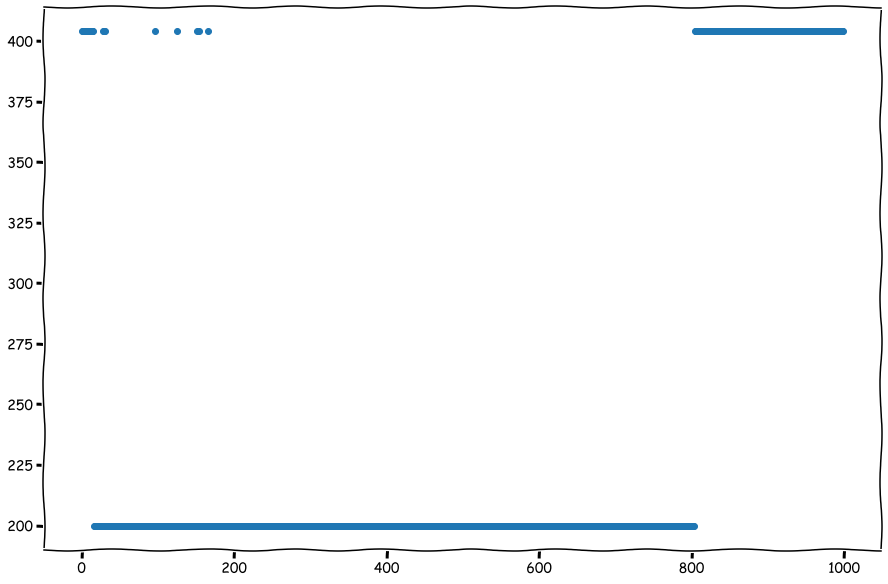

In [202]:
def jitter_dots(dots):
    offsets = dots.get_offsets()
    jittered_offsets = offsets
    # only jitter in the x-direction
    jittered_offsets[:, 0] += np.random.uniform(-0.3, 0.3, offsets.shape[0])
    dots.set_offsets(jittered_offsets)
    
dots = plt.scatter(x=status_codes.keys(), y=status_codes.values())
jitter_dots(dots)

plt.show()

In [203]:
len([i for i in status_codes.values() if i==200])

780

In [204]:
author_names = dumki_quotes.keys()
len(author_names)

64

In [214]:
print(dumki_quotes['Аўген Калубовіч'][0])

Дзе сёньня мяжа паміж свабодай і няволяй? Дзе крытэр, каб адрозьніць вольнага чалавека ад нявольніка? Гэтая мяжа – не турма. Сёньня ў турме можна быць больш вольным, чымся “на волі”. Мяжа паміж свабодай і няволяй у першую чаргу ў нас самых


In [ ]:
test_df = pd.DataFrame.from_dict(dumki_quotes, 
                      orient='index'
                      )
test_df.head()

In [217]:
quot_nums = np.sum(test_df.notnull(), axis=1)
quot_nums.head()

Янка Купала             24
Васіль Быкаў            51
Леў Сапега              10
Уладзімер Караткевіч    60
Рыгор Барадулін         10
dtype: int64

In [218]:
plt.xkcd()

<AxesSubplot:>

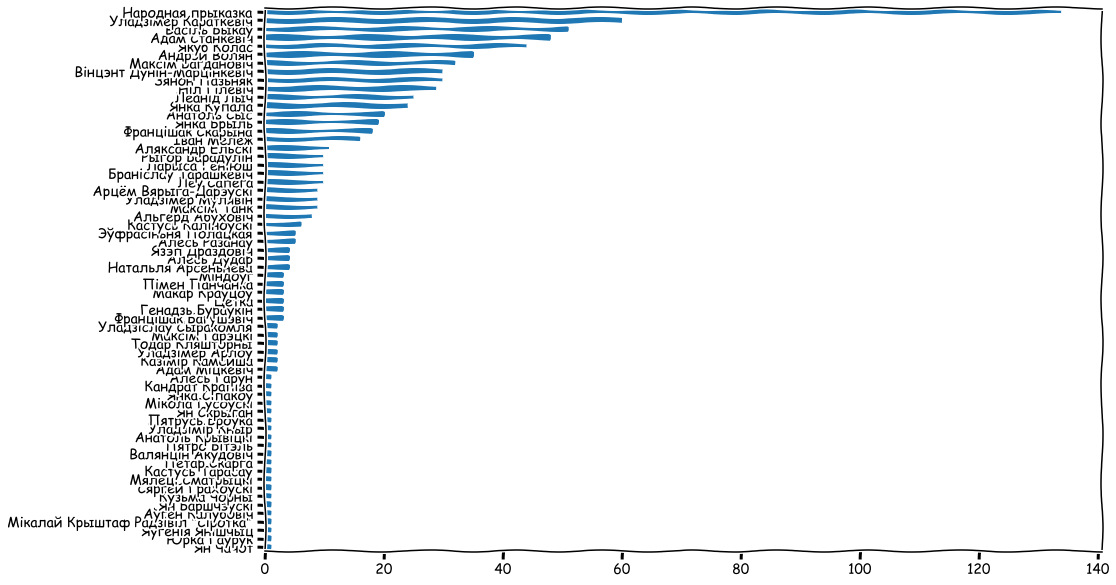

In [219]:
quot_nums.sort_values().plot.barh()

#### saving to csv

In [156]:
quote_source = 'data/smth'
'/'.join(quote_source.split("/")[:-1])
quote_source.split("/")[-1]

'smth'

In [161]:
def save_to_csv(quotes_dict: dict, quote_source: str):
    path = '/'.join(quote_source.split("/")[:-1])
    file_name = quote_source.split("/")[-1]
    print(f'{path=}')
    print(f'{file_name=}')
    
    quotes_tuples = [(quo, auth, file_name) for auth, quotes in quotes_dict.items() for quo in quotes]
    quote_df = pd.DataFrame(quotes_tuples, columns=['quote', 'author', 'source'])

    quote_df.to_csv(f'{path}/{file_name}_quotes.csv', index=None)

In [220]:
save_to_csv(dumki_quotes, 'data/dumki.org')

path='data'
file_name='dumki.org'


## nlb.by 
https://www.nlb.by/by/infarmatsyynyya-resursy/elektronnyya-infarmatsyynyya-resursy/resursy-natsyyanalnay-bibliyateki-belarusi/virtualnyya-praekty-vysta-ki-i-kalektsyi/virtualnyya-praekty-bibliyateki/klasiki-susvetnay-litaratury-yanka-kupala-i-yakub-/vyslo-i-vykazvanni-afaryzmy-belaruskikh-pesnyaro

#### scraping

In [ ]:
!pip install requests_html

In [1]:
URL = "https://www.nlb.by/by/infarmatsyynyya-resursy/elektronnyya-infarmatsyynyya-resursy/resursy-natsyyanalnay-bibliyateki-belarusi/virtualnyya-praekty-vysta-ki-i-kalektsyi/virtualnyya-praekty-bibliyateki/klasiki-susvetnay-litaratury-yanka-kupala-i-yakub-/vyslo-i-vykazvanni-afaryzmy-belaruskikh-pesnyaro"

In [118]:
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")

In [119]:
# for tf_tag in tqdm(soup.find_all('td')):
#     if tf_tag.descendants
txt_example = soup.find(string=re.compile('Асцярожна'))
txt_example

'Асцярожна, ясны пане,'

In [42]:
quotes_table = txt_example.find_parent('td').find_all('p')

In [43]:
quotes_table[:10]

[<p align="center"><strong><a name="1"></a>ГОНАР, ГОДНАСЦЬ ЧАЛАВЕКА, НАРОДА; ПАВАГА, ПАШАНА</strong></p>,
 <p><strong>Асцярожна, ясны пане,<br>
             З грозьбамі сваімі! </br></strong></p>,
 <p align="left"><em>Купала Я. Бандароўна [паэма, 1913] // Збор твораў: у 6 т. Т. 5. – Мінск, 1954. – С. 56. </em></p>,
 <p><strong>Вянкоў мы славы не насілі </strong></p>,
 <p align="left"><em>Купала Я. Наша мінуўшчына [верш, 1908–1910] // Збор твораў: у 6 т. Т. 2. – Мінск, 1952. – С. 180. </em></p>,
 <p><strong>І будзе ўнукаў панаванне<br>
             Там, дзе сягоння плача дзед! </br></strong></p>,
 <p align="left"><em>Купала Я. Ворагам Беларушчыны [верш, 1907] // Збор твораў: у 6 т. Т. 2. – Мінск, 1926. – С. 215. </em></p>,
 <p><strong>Кожны народ сам сабе пан</strong></p>,
 <p align="left"><em>Купала Я. Ворагам Беларушчыны [верш, 1907] // Збор твораў: у 6 т. Т. 2. – Мінск, 1926. – С. 215. </em></p>,
 <p><strong>Людзьмі звацца</strong></p>]

#### extraction

In [303]:
re.sub(r' +', ' ', "asd   .    fas     sdfsdfs")

'asd . fas sdfsdfs'

In [90]:
nlb_quotes = defaultdict(list)

author = None
quote = ''

for tag in quotes_table:
    align = tag.get('align')
    if align == 'center':
        continue

    for child in tag.children:
        # print(f'{child=}')
        if child.name == 'em':
            # print(f'{child.string=}')
            author = child.get_text()
        elif child.name == 'br':
            quote += '\n'
        else:
            # print(child.get_text())
            text = re.sub(r' +', ' ', child.get_text())
            text = re.sub(r'\n ', '\n', text)
            quote += text
            
                
    if author is not None:
        nlb_quotes[author].append(quote.strip())
        author = None
        quote = ''


In [98]:
list(map(print, [(k, v) for k, v in nlb_quotes.items()][:7]))
pass

('Купала Я. Бандароўна [паэма, 1913] // Збор твораў: у 6 т. Т. 5. – Мінск, 1954. – С. 56. ', ['Асцярожна, ясны пане,\nЗ грозьбамі сваімі!', 'Асцярожна, ясны пане,\nЗ грозьбамі сваімі!'])
('Купала Я. Наша мінуўшчына [верш, 1908–1910] // Збор твораў: у 6 т. Т. 2. – Мінск, 1952. – С. 180. ', ['Вянкоў мы славы не насілі', 'Вянкоў мы славы не насілі'])
('Купала Я. Ворагам Беларушчыны [верш, 1907] // Збор твораў: у 6 т. Т. 2. – Мінск, 1926. – С. 215. ', ['І будзе ўнукаў панаванне\nТам, дзе сягоння плача дзед!', 'Кожны народ сам сабе пан', 'І будзе ўнукаў панаванне\nТам, дзе сягоння плача дзед!', 'Кожны народ сам сабе пан'])
('Купала Я. А хто там ідзе? [верш, 1905–1907] // Збор твораў: у 6 т. Т. 1. – Мінск, 1951. – С. 270.', ['Людзьмі звацца', 'Людзьмі звацца'])
('Купала Я. Маё цярпенне [верш, 1915] // Збор твораў: у 6 т. Т. 3. – Мінск, 1953. – С. 216. ', ['Мой крык перад малітвай свету – ноль!', 'Мой крык перад малітвай свету – ноль!'])
('Купала Я. Мужык [верш, 1905] // Збор твораў: у 6 т. Т

In [99]:
print(nlb_quotes['Купала Я. Роднае слова [верш, 1908] // Збор твораў: у 9 т. Т. 2 : Вершы, пераклады, 1908–1910. – Мінск, 1996. – С. 35. '][0])

Магутнае слова, ты, роднае слова! 
Са мной ты на яве і ў сне; 
Душу мне затрэсла пагудкаю новай, 
Ты песень наўчыла мяне. Бяссмертнае слова, ты, роднае слова! 
Ты крыўды, няпраўды змагло; 
Хоць гналі цябе, накладалі аковы, 
Дый дарма: жывеш, як жыло! Свабоднае слова, ты, роднае слова! 
Зайграй ты смялей, весялей! 
Хоць гадзіны сыкаюць, кружацца совы, 
Жывеш ты на хвалу людзей. Загнанае слова, ты, роднае слова! 
Грымі ж над радзімай зямлёй: 
Што родная мова, хоць бедная мова, 
Мілей найбагатшай чужой!


In [100]:
for n, i in enumerate(nlb_quotes.keys()):
    print(i, '\n')
    if n > 8:
        break

Купала Я. Бандароўна [паэма, 1913] // Збор твораў: у 6 т. Т. 5. – Мінск, 1954. – С. 56.  

Купала Я. Наша мінуўшчына [верш, 1908–1910] // Збор твораў: у 6 т. Т. 2. – Мінск, 1952. – С. 180.  

Купала Я. Ворагам Беларушчыны [верш, 1907] // Збор твораў: у 6 т. Т. 2. – Мінск, 1926. – С. 215.  

Купала Я. А хто там ідзе? [верш, 1905–1907] // Збор твораў: у 6 т. Т. 1. – Мінск, 1951. – С. 270. 

Купала Я. Маё цярпенне [верш, 1915] // Збор твораў: у 6 т. Т. 3. – Мінск, 1953. – С. 216.  

Купала Я. Мужык [верш, 1905] // Збор твораў: у 6 т. Т. 5. – Мінск, 1951. – С. 60. 

Купала Я. Пакахай мяне, дзяўчынка... [верш, 1908–1910] // Збор твораў: у 6 т. Т. 2. – Мінск, 1952. – С. 219. 

Колас Я. Новая зямля [паэма, 1910–1923] // Збор твораў: у 7 т. Т. 4. – Мінск, 1952. – С. 221. 

Своеасаблівая прымаўка (прыгаворка), якую на працягу ўсёй камедыі “Паўлінка” (1912) ужывае Сцяпан Крыніцкі, звяртаючыся да іншых асоб п’есы. 
            Купала Я. Паўлінка [п’еса, 1912] // Збор твораў: у 6 т. Т. 6. – Мінск,

In [ ]:
a = set(1, 2, 1)
a.update()

In [103]:
clean_nlb_quotes = defaultdict(set)
for auth, quotes in nlb_quotes.items():
    auth: str
    if auth.startswith("Купала"):
        clean_nlb_quotes['Янка Купала'].update(quotes)
    elif auth.startswith("Колас"):
        clean_nlb_quotes['Якуб Колас'].update(quotes)
    else:
        clean_nlb_quotes[auth].update(quotes)

In [104]:
clean_nlb_quotes.keys()

dict_keys(['Янка Купала', 'Якуб Колас', 'Своеасаблівая прымаўка (прыгаворка), якую на працягу ўсёй камедыі “Паўлінка” (1912) ужывае Сцяпан Крыніцкі, звяртаючыся да іншых асоб п’есы. \n            Купала Я. Паўлінка [п’еса, 1912] // Збор твораў: у 6 т. Т. 6. – Мінск, 1954. – С. 172. '])

In [106]:
clean_nlb_quotes.pop('Своеасаблівая прымаўка (прыгаворка), якую на працягу ўсёй камедыі “Паўлінка” (1912) ужывае Сцяпан Крыніцкі, звяртаючыся да іншых асоб п’есы. \n            Купала Я. Паўлінка [п’еса, 1912] // Збор твораў: у 6 т. Т. 6. – Мінск, 1954. – С. 172. ')

{'Каханенькая, родненькая'}

In [107]:
clean_nlb_quotes.keys()

dict_keys(['Янка Купала', 'Якуб Колас'])

#### data explorateion

<BarContainer object of 2 artists>

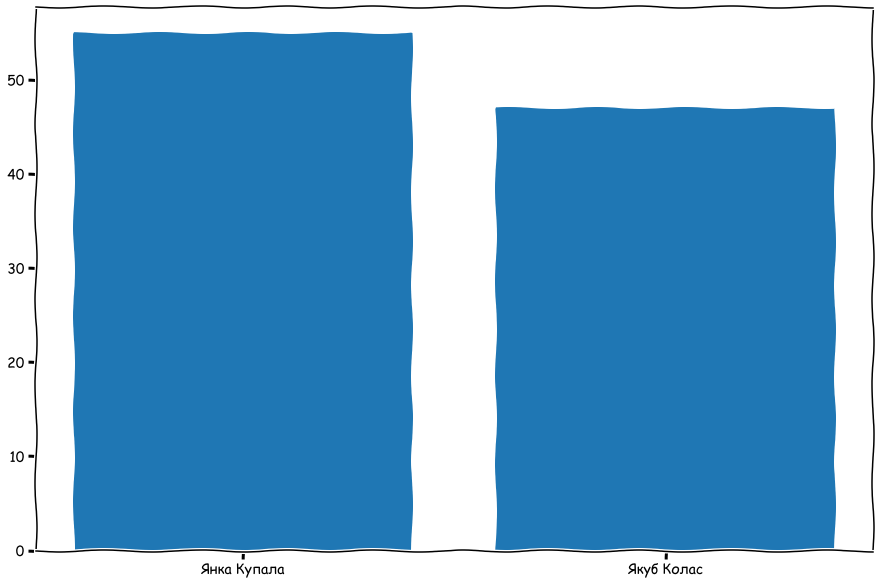

In [127]:
plt.bar(height=[len(s) for s in clean_nlb_quotes.values()], x=clean_nlb_quotes.keys())

#### saving to csv

In [162]:
save_to_csv(clean_nlb_quotes, 'data/nlb.by')

path='data'
file_name='nlb.by'


## svaboda.org
https://www.svaboda.org/a/24255332.html

#### scraping

In [33]:
URL="https://www.svaboda.org/a/24255332.html"
page = requests.get(URL)
soup = BeautifulSoup(page.content, "html.parser")

results = soup.find_all('div', class_="wsw")
len(results)

3

In [34]:
svaboda_quotes = results[0]

In [35]:
svaboda_raw = [txt for txt in svaboda_quotes.text.split('\n') if txt != ""]
svaboda_raw[:20]

['Гасподзь схіляецца да ўсіх, ды ніцых духам Ён ня чуе.',
 'Ніна Мацяш',
 'Хоць, праўда, хлеб ядуць і з вуды, але не ўсе і не заўсюды. ',
 'Якуб Колас',
 'Гаршчок агорнуты пашанай, хоць ён фаміліі глінянай.',
 ' Якуб Колас',
 'Паэт – ён гарыць, як балючы гузак на лобе абражанага народу.',
 ' Рыгор Барадулін',
 'Кожны раз чалавецтва бліжэй да шчасьця на вышыню нашых магіл.',
 'Кастусь Каліноўскі',
 'Мы павінны быць рабамі законаў для таго, каб мець магчымасьць карыстацца свабодай.',
 'Леў Сапега',
 'Кожны народ мае хаця б адзін геніяльны твор, і гэты твор - мова.',
 'Алесь Разанаў',
 'Горай ня будзе, бо лепш не было.',
 'Уладзімер Някляеў',
 'Як ад нараджэньня зьвяры, што ходзяць у пустыні, ведаюць ямы свае; птушкі, што лётаюць у паветры, ведаюць гнёзды свае; рыбы, што плаваюць па моры і ў рэках, чуюць віры свае; пчолы і тым падобныя бароняць вульлі свае, – так і людзі, дзе нарадзіліся і ўскормлены, да таго месца вялікую ласку маюць. ',
 'Францішак Скарына',
 'Кожны чалавек носіць сваё 

In [36]:
len(svaboda_raw)

182

In [37]:
svaboda_quotes = defaultdict(list)
for author, quote in zip(svaboda_raw[1::2], svaboda_raw[0::2]):
    svaboda_quotes[author.strip()].append(quote.strip())

In [38]:
list(svaboda_quotes.items())[:5]

[('Ніна Мацяш',
  ['Гасподзь схіляецца да ўсіх, ды ніцых духам Ён ня чуе.',
   'Гасподзь схіляецца да ўсіх, ды ніцых духам Ён ня чуе.']),
 ('Якуб Колас',
  ['Хоць, праўда, хлеб ядуць і з вуды, але не ўсе і не заўсюды.',
   'Гаршчок агорнуты пашанай, хоць ён фаміліі глінянай.',
   'Добра быць у дарозе, якую ты сам сабе выбіраеш.',
   'У істоце кожнага страху ляжыць наша няведаньне, наша цемната.',
   'Сьмерць кожны дзень ходзіць вакол, кожную хвіліну нішчыць і маладзенькія, і старыя формы жыцьця, і мы не зварачаем на гэта ўвагі, і толькі тады яна робіць моцнае ўражаньне, калі ўмірае хто блізкі або калі наваліцца мор і людзі пачынаюць уміраць агулам – тады чалавека ахоплівае жах і ён губляе галаву. І вось што цікава. Калі парушаюцца драбязговыя правы, то чалавек гатоў грызьціся за гэта і кусацца зубамі; там жа, дзе разьбіваецца сама аснова, прынцып, ён згінае сваю галаву і моўчкі падстаўляе яе пад абух.',
   'Крыкі спрэчкі не разьвяжуць.',
   'Назад ня прыйдзе хваля тая, што з быстрай рэ

#### data exploration

In [39]:
svaboda_df = pd.DataFrame.from_dict(svaboda_quotes, 
                      orient='index'
                      )
print(svaboda_df.shape)
svaboda_df.head()

(47, 9)


,0,1,2,3,4,5,6,7,8
Ніна Мацяш,"Гасподзь схіляецца да ўсіх, ды ніцых духам Ён ...","Гасподзь схіляецца да ўсіх, ды ніцых духам Ён ...",None,None,None,None,None,None,None
Якуб Колас,"Хоць, праўда, хлеб ядуць і з вуды, але не ўсе ...","Гаршчок агорнуты пашанай, хоць ён фаміліі глін...","Добра быць у дарозе, якую ты сам сабе выбіраеш.",У істоце кожнага страху ляжыць наша няведаньне...,"Сьмерць кожны дзень ходзіць вакол, кожную хвіл...",Крыкі спрэчкі не разьвяжуць.,"Назад ня прыйдзе хваля тая, што з быстрай рэчк...","Корань навукі горкі, ды плады яго салодкія.",Без атак і абароны няма сапраўднае вайны.
Рыгор Барадулін,"Паэт – ён гарыць, як балючы гузак на лобе абра...",Сорам у спадчыну не пераходзіць.,"Якім бы велічным ні здаваўся трон, усё роўна н...","І датуль чалавек жывы, покуль зь ім душа разма...","І датуль чалавек жывы, покуль зь ім душа разма...","Адчуваю сябе лепш, чым было, але горш, чым хац...",None,None,None
Кастусь Каліноўскі,Кожны раз чалавецтва бліжэй да шчасьця на вышы...,"Не народ для ўрада, а ўрад для народа.","Няма, браткі, большага шчасьця на гэтым сьвеце...",None,None,None,None,None,None
Леў Сапега,"Мы павінны быць рабамі законаў для таго, каб м...","Для прыстойнага чалавека няма большай асалоды,...",None,None,None,None,None,None,None


In [40]:
quot_nums = np.sum(svaboda_df.notnull(), axis=1)
quot_nums[:20]

Ніна Мацяш              2
Якуб Колас              9
Рыгор Барадулін         6
Кастусь Каліноўскі      3
Леў Сапега              2
Алесь Разанаў           3
Уладзімер Някляеў       2
Францішак Скарына       1
Уладзімер Караткевіч    6
Васіль Быкаў            4
Аляксандар Ельскі       1
Ларыса Геніюш           2
Зянон Пазьняк           3
Уладзімер Арлоў         2
Кузьма Чорны            1
Кандрат Крапіва         1
Максім Танк             7
Янка Брыль              2
Ігар Бабкоў             1
Ян Скрыган              1
dtype: int64

In [41]:
plt.xkcd()

<AxesSubplot:>

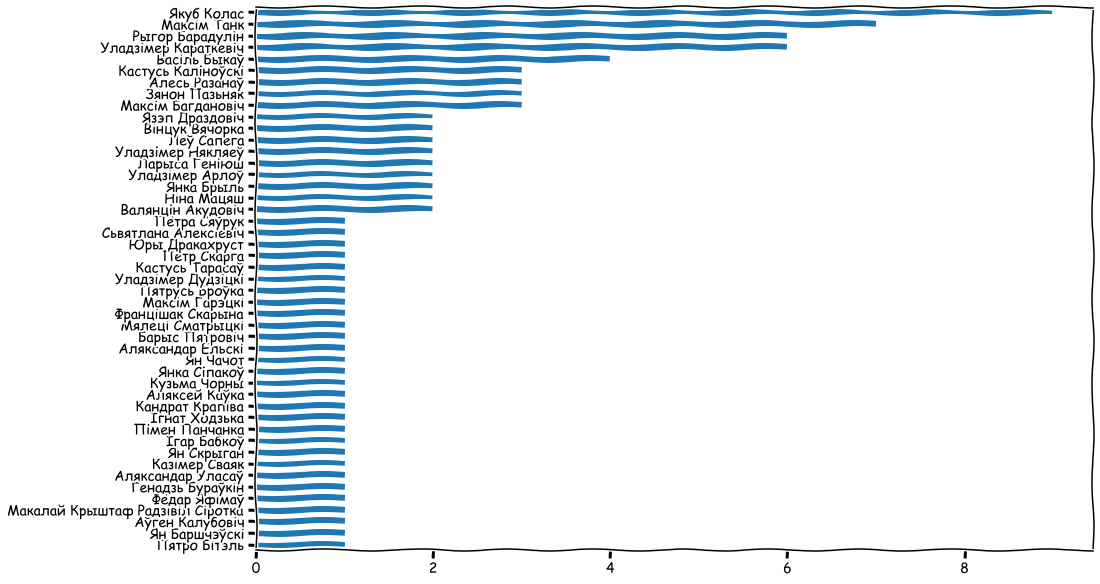

In [42]:
quot_nums.sort_values().plot.barh()

#### saving csv

In [44]:
save_to_csv(svaboda_quotes, 'data/svaboda.org_a_24255332.html')

## let's concat

In [222]:
list(filter(lambda t: not t.startswith('.'), os.listdir('data')))

['nlb.by_quotes.csv',
 'svaboda.org_a_24255332.html_quotes.csv',
 'dumki.org_quotes.csv']

In [223]:
csv_files = filter(lambda t: not t.startswith('.'), os.listdir('data'))
nlb, svaboda, dumki = map(pd.read_csv, [f'data/{name}' for name in csv_files])

In [224]:
dumki.head(2)

,quote,author,source
0,"Паўстань, народ! Прачніся, беларусе!\r\nЗірні ...",Янка Купала,dumki.org
1,"З квяцістымі сонечнымі думкамі, з нязломнай ве...",Янка Купала,dumki.org


In [225]:
nlb.head(2)

,quote,author,source
0,"І будзе ўнукаў панаванне\nТам, дзе сягоння пла...",Янка Купала,nlb.by
1,Няма для духа вольнага граніцы,Янка Купала,nlb.by


In [226]:
svaboda.head(2)

,quote,author,source
0,"Гасподзь схіляецца да ўсіх, ды ніцых духам Ён ...",Ніна Мацяш,svaboda.org_a_24255332.html
1,"Гасподзь схіляецца да ўсіх, ды ніцых духам Ён ...",Ніна Мацяш,svaboda.org_a_24255332.html


In [238]:
result_df = pd.concat([nlb, svaboda, dumki])
result_df.head()

,quote,author,source
0,"І будзе ўнукаў панаванне\nТам, дзе сягоння пла...",Янка Купала,nlb.by
1,Няма для духа вольнага граніцы,Янка Купала,nlb.by
2,"Песні, знайце, – сэрца дар",Янка Купала,nlb.by
3,Ад прадзедаў спакон вякоў \nМне засталася спад...,Янка Купала,nlb.by
4,"Нам трэба жыць і долю папраўляць, \nКаб нас па...",Янка Купала,nlb.by


#### duplicates

In [294]:
print(string.punctuation)
string.whitespace

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


' \t\n\r\x0b\x0c'

In [94]:
result_df['low_text'] = result_df['quote'].str.replace(rf'[{string.punctuation}]', ' ').str.replace(rf'[{string.whitespace}]', ' ').str.lower().str.strip()

/var/folders/dr/5phn3sld4g54qs4f08mhmc5w0000gn/T/ipykernel_4923/1177343392.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  result_df['low_text'] = result_df['quote'].str.replace(rf'[{string.punctuation}]', ' ').str.replace(rf'[{string.whitespace}]', ' ').str.lower().str.strip()


In [98]:
result_df.low_text = result_df.low_text.apply(lambda t: re.sub(r' +', ' ', t))

In [99]:
result_df.head()

,quote,author,source,low_text
0,"І будзе ўнукаў панаванне\nТам, дзе сягоння пла...",Янка Купала,nlb.by,і будзе ўнукаў панаванне там дзе сягоння плача...
1,Няма для духа вольнага граніцы,Янка Купала,nlb.by,няма для духа вольнага граніцы
2,"Песні, знайце, – сэрца дар",Янка Купала,nlb.by,песні знайце – сэрца дар
3,Ад прадзедаў спакон вякоў \nМне засталася спад...,Янка Купала,nlb.by,ад прадзедаў спакон вякоў мне засталася спадчы...
4,"Нам трэба жыць і долю папраўляць, \nКаб нас па...",Янка Купала,nlb.by,нам трэба жыць і долю папраўляць каб нас патом...


#### difference in size between lists of duplicates in clean text and in dirty text

In [100]:
result_df[result_df.duplicated(subset='quote', keep=False)].sort_values(by='quote').shape, result_df[result_df.duplicated(subset='low_text', keep=False)].sort_values(by='quote').shape

((22, 4), (115, 4))

In [102]:
result_df[result_df.duplicated(subset='low_text', keep=False)].sort_values(by='quote')

342    І датуль чалавек жывы, покуль зь ім душа разма...
116    І датуль чалавек жывы, покуль зь ім душа разма...
117    І датуль чалавек жывы, покуль зь ім душа разма...
483    І фанатыкі, і бязбожнікі, — адной маткі дзеці ...
165    І фанатыкі, і бязбожнікі, — адной маткі дзеці ...
                             ...                        
156    Я такіх паэтаў не страчаў, якія маглі б напіса...
413    Як ад нараджэньня зьвяры, што ходзяць у пустын...
129    Як ад нараджэньня зьвяры, што ходзяць у пустын...
475    Яшчэ нікому не ўдавалася закратаваць вакно памяці
146    Яшчэ нікому не ўдавалася закратаваць вакно пам...
Name: quote, Length: 115, dtype: object

In [108]:
result_df = result_df.drop_duplicates(subset='low_text', keep='first')

#### saving csv

In [109]:
result_df.to_csv('data/all_quotes.csv', index=None)

#### todo: exploration

In [4]:
all_quotes = pd.read_csv('data/all_quotes.csv')
all_quotes.head()

,quote,author,source,low_text
0,"І будзе ўнукаў панаванне\nТам, дзе сягоння пла...",Янка Купала,nlb.by,і будзе ўнукаў панаванне там дзе сягоння плача...
1,Няма для духа вольнага граніцы,Янка Купала,nlb.by,няма для духа вольнага граніцы
2,"Песні, знайце, – сэрца дар",Янка Купала,nlb.by,песні знайце – сэрца дар
3,Ад прадзедаў спакон вякоў \nМне засталася спад...,Янка Купала,nlb.by,ад прадзедаў спакон вякоў мне засталася спадчы...
4,"Нам трэба жыць і долю папраўляць, \nКаб нас па...",Янка Купала,nlb.by,нам трэба жыць і долю папраўляць каб нас патом...


<AxesSubplot:>

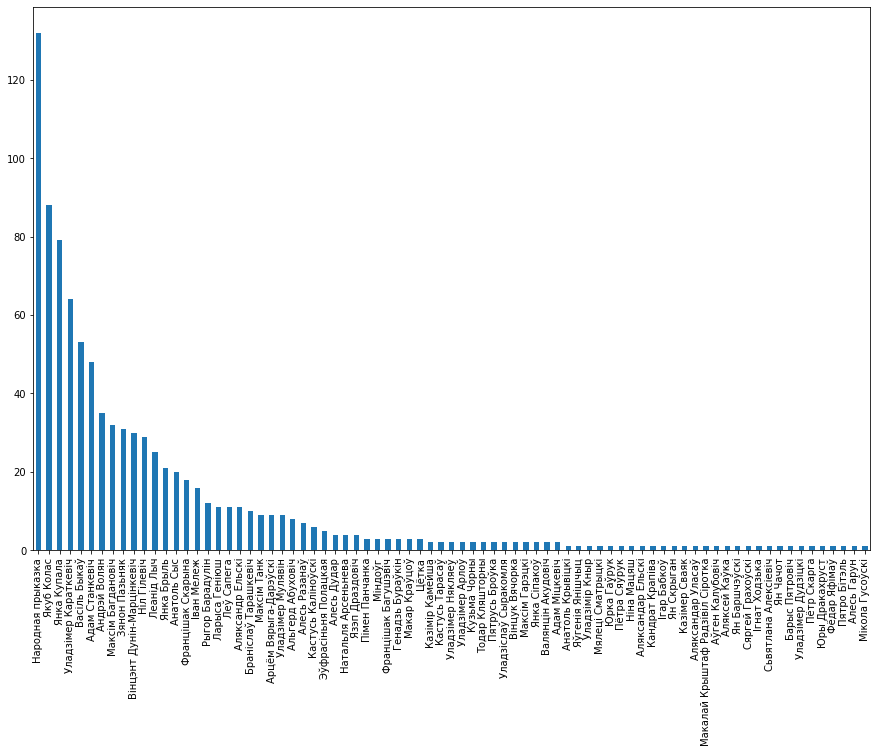

In [5]:
all_quotes['author'].value_counts().plot(kind='bar')

In [10]:
quotes_amount = all_quotes['author'].value_counts()

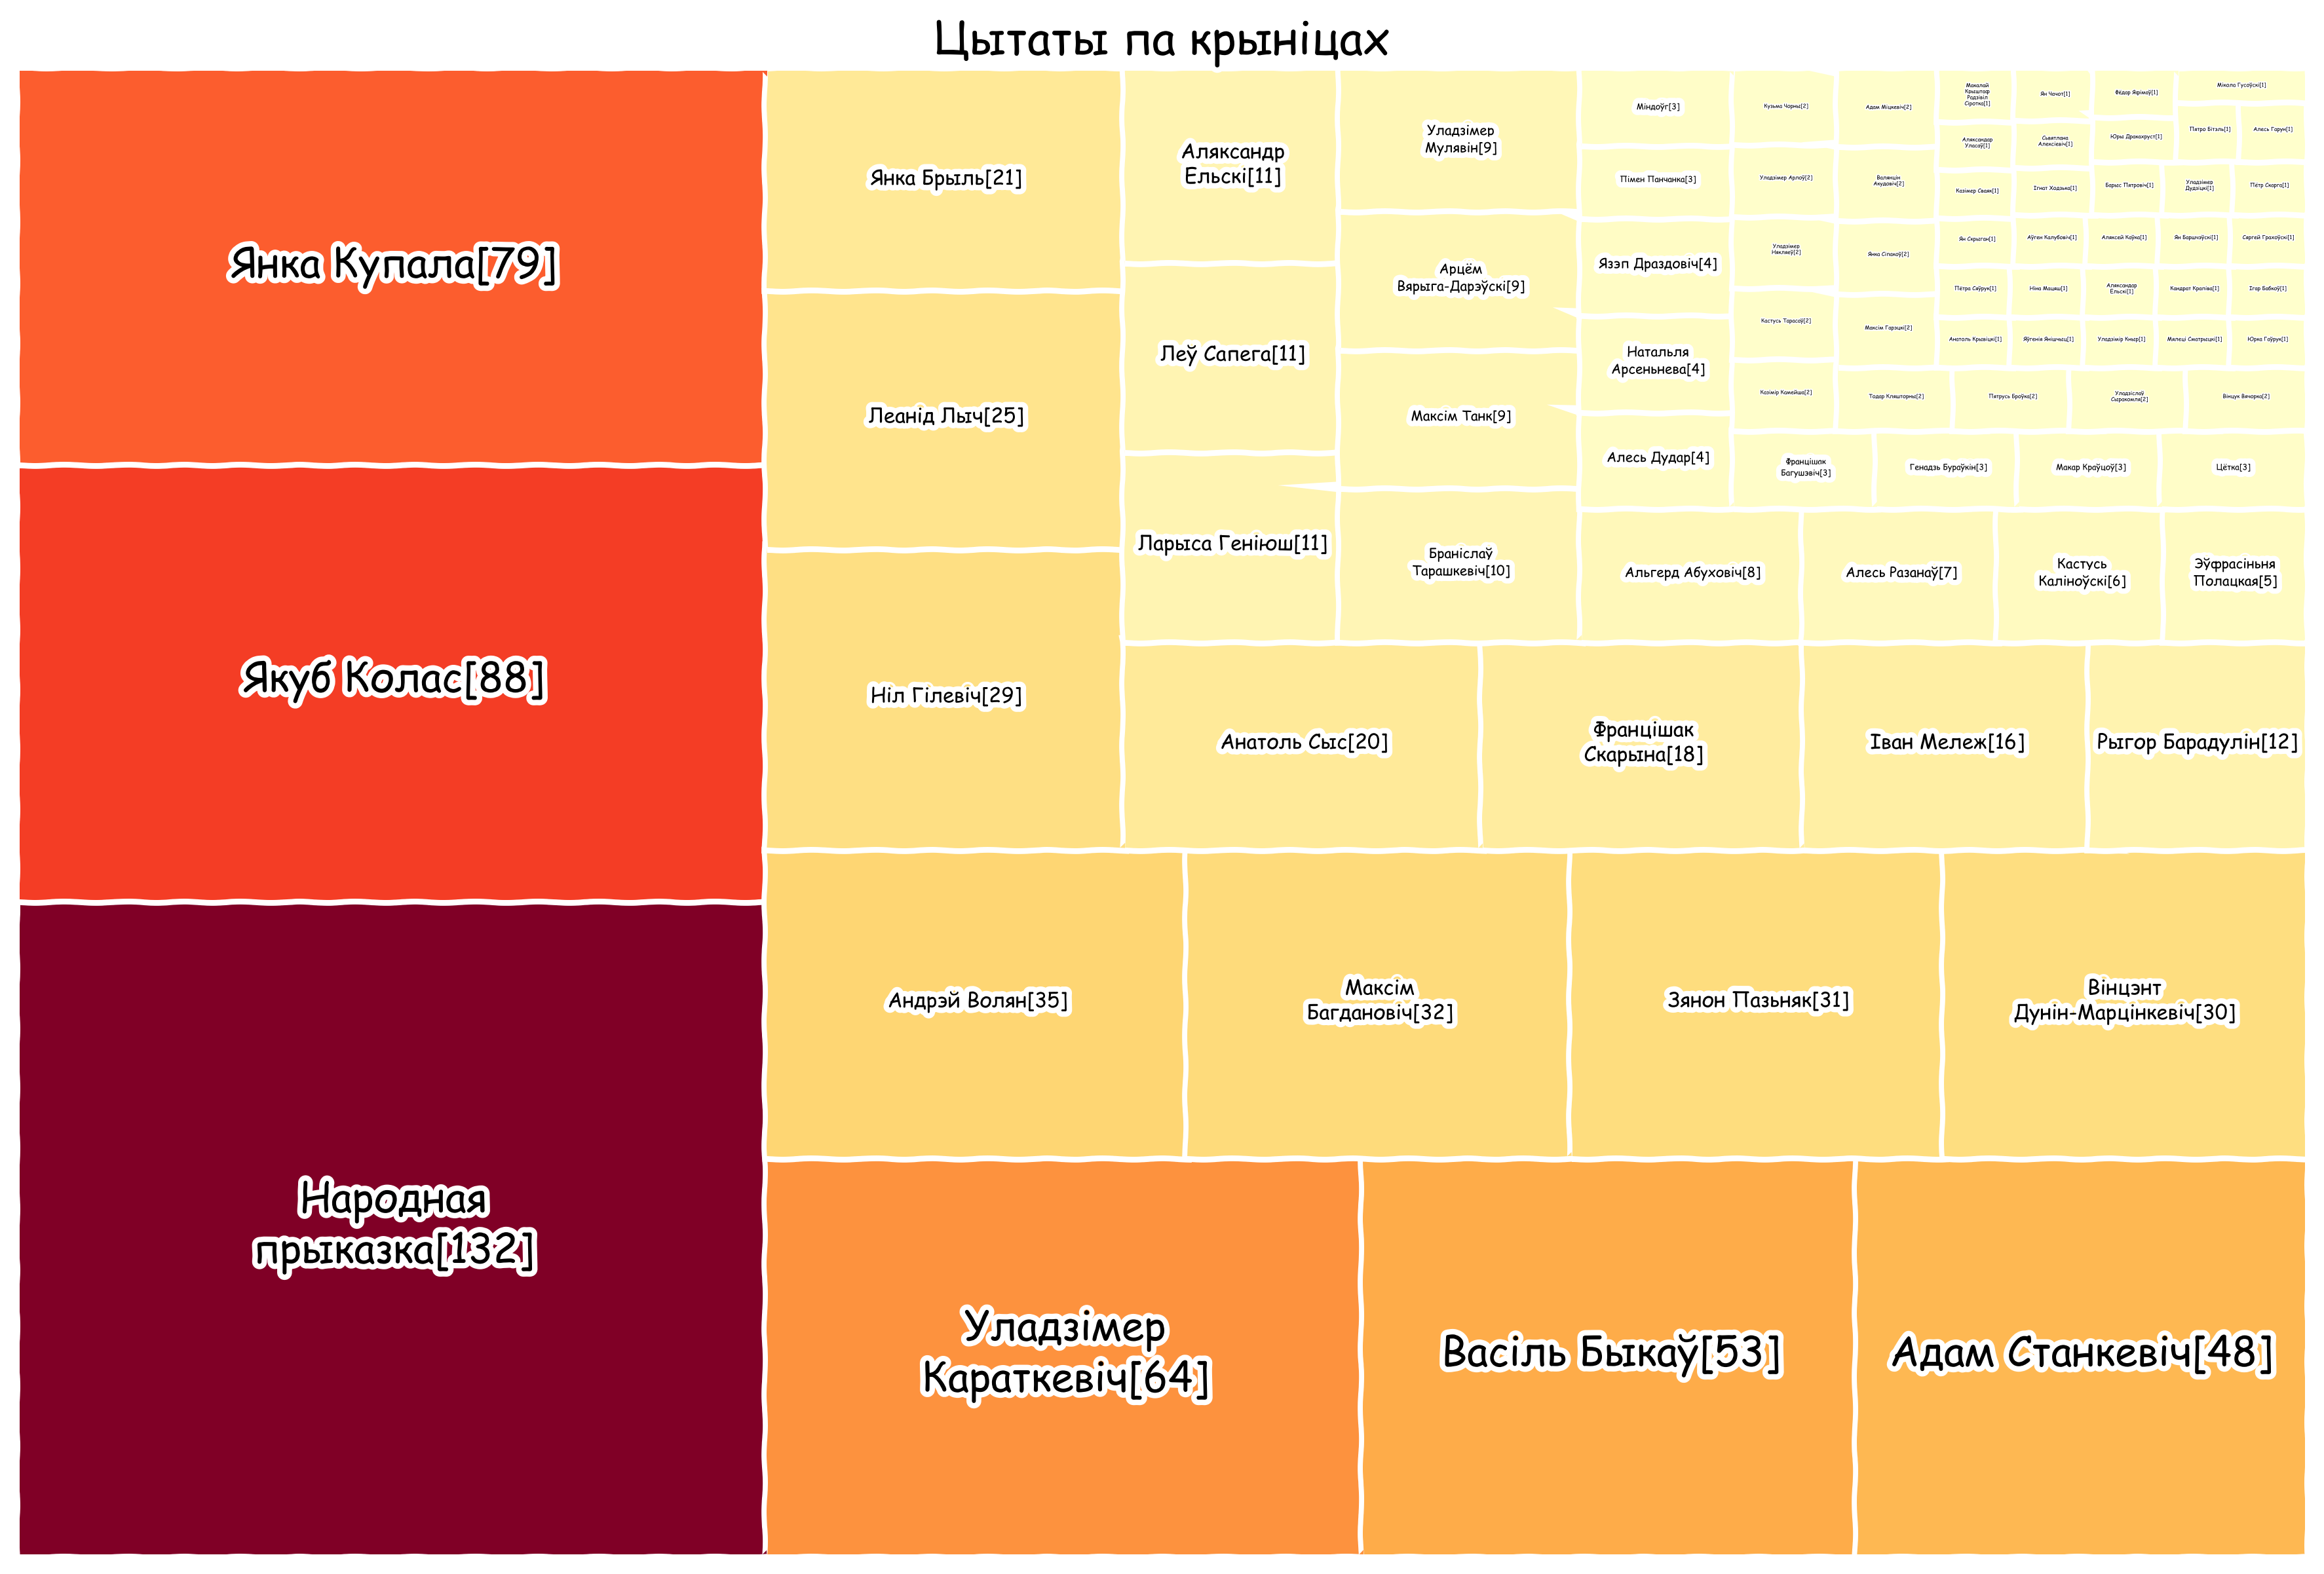

In [105]:
## SO MUCH HARDCODE, NOT GOOD
fig = plt.figure()
fig.dpi = 300

cmap = matplotlib.cm.YlOrRd
mini=min(quotes_amount)
maxi=max(quotes_amount)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in quotes_amount]

labels = []
for lbl, val in quotes_amount.items():
    label = f'{lbl}[{val}]'
    if len(label) >= 20:
        label = '\n'.join(label.split(' '))
    
    labels.append(label)


with plt.xkcd():
    ax = squarify.plot(
        quotes_amount,
        # label=labels,
        color=colors,
    )

    for patch, value, label in zip(ax.patches, quotes_amount.values, labels):
        left, bottom, width, height = patch.get_bbox().bounds
        
        if value > 47:
            label_size = 15
        elif value > 10:
            label_size = 7.5
        elif value > 3:
            label_size = 5
        elif value > 2:
            label_size = 3
        else:
            label_size = 2
            ax.annotate(
                    label,
                    xy=(left+width/2, 
                        bottom+height/2),
                    ha='center',
                    va='center',
                    rotation=0,
                    fontsize=label_size,

                    path_effects=[pe.withStroke(linewidth=1, foreground='white')]
            )
            # patch.set_backgroundcolor('none')
            continue
        
        # label_size = width * 29 * 0.3 / len(label)
        
        ax.annotate(
                    label,
                    xy=(left+width/2, 
                        bottom+height/2),
                    ha='center',
                    va='center',
                    rotation=0,
                    fontsize=label_size)
        
    plt.title('Цытаты па крыніцах')
    plt.axis('off')